In [1]:
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2
import numpy as np
import pyBigWig


In [2]:
def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [3]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [4]:
def get_proity_region(df_in, priority = [
    "promoter",
    "UTR",
    "exon",
    "intron",
    "intergenic"   ]

):
    df_in['annotation'] = priority[-1]
    df_in = df_in.loc[:,priority+['id']]
    priorityi = priority[::-1]
    for column in priorityi:
        df_in.loc[df_in[column]==True,"annotation"] = column
    return df_in

In [5]:
bed_allpeaks = "/data2st1/junyi/output/atac0416/cCRE/peak.bed"


bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"

#https://www.encodeproject.org/annotations/ENCSR127YRL/
bed_rdhs = "/data2st1/junyi/output/atac0416/cCRE/ENCFF414KHO.bed"



In [6]:
merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [7]:
inter_rdhs, non_overlapping_rdhs = intersect_bed_files(bed_allpeaks, bed_rdhs)

In [8]:
inter_rdhs.saveas("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed")
non_overlapping.saveas("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed")

<BedTool(/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed)>

In [9]:
len(merged), len(non_overlapping)

(295713, 1534765)

In [10]:
len(inter_rdhs), len(non_overlapping_rdhs)

(840623, 1836114)

In [11]:
bedall_peaks = BedTool(bed_allpeaks)

In [12]:
df_allpeaks = pd.read_csv(bed_allpeaks, sep="\t", header=None) 
df_allrdhs = pd.read_csv(bed_rdhs, sep="\t", header=None)

In [13]:
n_overlap = len(inter_rdhs)
n_cCRE = len(df_allpeaks)
n_rDHS = len(df_allrdhs)

In [14]:
df_encodeCCRE = pd.read_csv(bed_encode, sep="\t", header=None)

In [15]:
n_overlap_cCRE = len(merged)
n_encodeCCRE = len(df_encodeCCRE)

In [16]:
venn2(subsets=( n_cCRE-n_overlap, n_rDHS-n_overlap, n_overlap), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_rdhs.svg", dpi=300, bbox_inches='tight')
plt.close()

In [17]:
venn2(subsets=( n_cCRE-n_overlap_cCRE, n_encodeCCRE-n_overlap_cCRE, n_overlap_cCRE), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_CCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

In [18]:
df_allpeaks.columns = ["chr", "start", "end"]

In [19]:
df_allpeaks['names'] = df_allpeaks['chr'] + ":" + df_allpeaks['start'].astype(str) + "-" + df_allpeaks['end'].astype(str)

In [20]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    #"/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
    "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
    "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed",
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
]
dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/peak.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot[name] = df_annot
        print(f"Processed {file},{len(dict_annot[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue


# dict_annot = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_allpeaks,region_col='names', bedfile=file)
#         dict_annot[name] = df_annot[df_annot.distance==0]
#         dict_annot['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot[name])}")
#     except:
#         print(f"Error processing {file}")
#         continue


Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,2768449
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,523848
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,106103
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,333429
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,520524
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,352975
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,23833
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,460411


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,139236


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,282254


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,881899
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,892769


In [71]:

gene_regions = {
    'intron': set(dict_annot['intron_selected'].names),
    'exon': set(dict_annot['exon_selected'].names),
    'promoter': set(dict_annot['promoter2k'].names),
    'UTR': set(dict_annot['UTR'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)

In [72]:
df_allpuei = gene_regions.reset_index()

In [73]:
df_allpuei = get_proity_region(df_allpuei)

/tmp/ipykernel_1954143/2052237438.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'intergenic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_in.loc[df_in[column]==True,"annotation"] = column


In [77]:
df_allpuei

,promoter,UTR,exon,intron,intergenic,id,annotation
0,False,True,True,True,False,chr1:136479516-136480017,UTR
1,False,False,False,True,False,chr15:89227497-89227998,intron
2,False,False,True,True,False,chr13:13474543-13475044,exon
3,False,False,False,True,True,chr13:103703857-103704358,intron
4,False,False,False,True,False,chr18:42768123-42768624,intron
...,...,...,...,...,...,...,...
1344944,False,False,False,False,True,chr19:59651780-59652281,intergenic
1344945,False,False,False,False,True,chr9:98158351-98158852,intergenic
1344946,False,False,False,False,True,chr4:52506534-52507035,intergenic
1344947,False,False,False,False,True,chr4:93560090-93560591,intergenic


In [74]:
df_allpuei_c = df_allpuei.groupby(['annotation']).size().reset_index(name='counts')

In [76]:
df_allpuei_c

,annotation,counts
0,UTR,49077
1,exon,108140
2,intergenic,557910
3,intron,586021
4,promoter,43801


<Axes: ylabel='counts'>

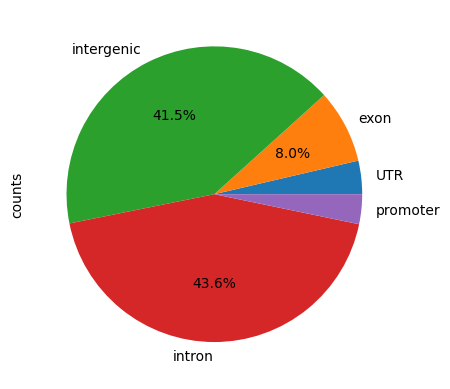

In [75]:
df_allpuei_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

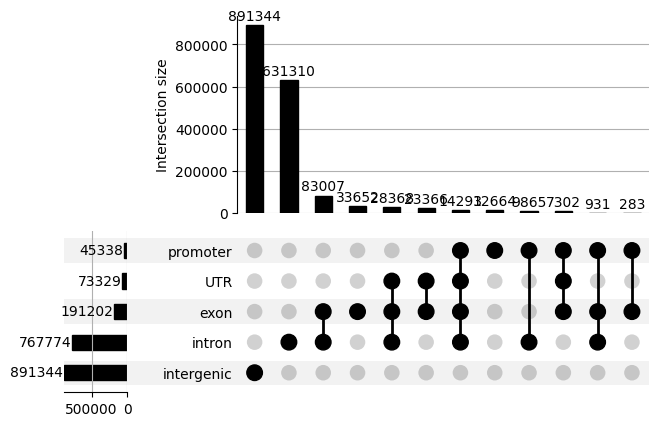

In [26]:

ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [27]:
gene_regions = {
    # 'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    # 'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)

/tmp/ipykernel_1954143/4136633866.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


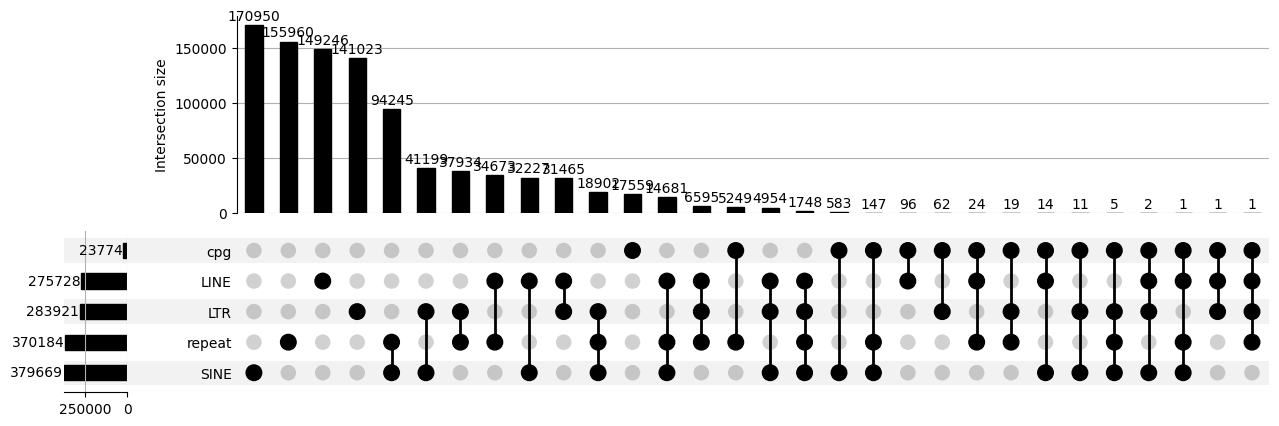

In [28]:
upset = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True)
ax_dict = upset.plot()
# for rect in ax_dict['intersections'].containers:
#     ax_dict['intersections'].bar_label(
#         rect,
#         rotation=45
#     )
# upset = UpSet(gene_regions, subset_size="count", sort_by="cardinality")
# ax_dict2 = upset.plot()

plt.tight_layout()
plt.show()
gene_regions_peaks = gene_regions

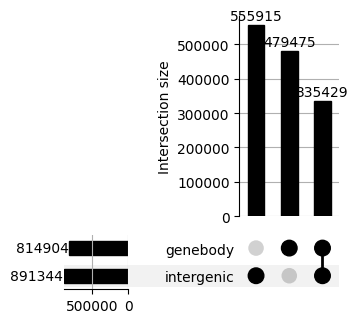

In [29]:
gene_regions = {
    'genebody': set(dict_annot['genebody'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [30]:
# If the peak macs ends
df_allpeaks = pd.read_csv("/data2st1/junyi/output/atac0416/iterative/peaks.csv",index_col=0)

In [31]:
df_allpeaks.set_index('Peaks', inplace=True)

In [32]:
df_nonoverlapping = pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed", sep="\t", header=None)    

In [33]:
df_nonoverlapping["names"] = df_nonoverlapping[0] + ":" + df_nonoverlapping[1].astype(str) + "-" + df_nonoverlapping[2].astype(str) 

In [34]:
df_overlapping = pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed", sep="\t", header=None)
df_overlapping["names"] = df_overlapping[0] + ":" + df_overlapping[1].astype(str) + "-" + df_overlapping[2].astype(str)

In [35]:
#df_overlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).difference(set(df_allpeaks.index.values)))]
df_unoverlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).intersection(set(df_allpeaks.index.values)))]
df_overlap = df_allpeaks.loc[list(set(df_overlapping.names.values).intersection(set(df_allpeaks.index.values)))]

In [36]:
df_unoverlap_count = df_unoverlap.sum(axis=1).reset_index()

In [37]:
df_overlap_count = df_overlap.sum(axis=1).reset_index()

In [38]:
df_overlap_count["count"] = df_overlap_count[0].clip(0,10)
df_unoverlap_count["count"] = df_unoverlap_count[0].clip(0,10)

In [39]:
df_unoverlap_count.groupby("count").size().reset_index(name='counts')

,count,counts
0,1,407045
1,2,161164
2,3,88830
3,4,59317
4,5,44510
5,6,34776
6,7,28615
7,8,23966
8,9,20633
9,10,262381


In [40]:
df_overlap_count.groupby("count").size().reset_index(name='counts').counts

0    123068
1     69049
2     45250
3     33473
4     26924
5     21640
6     18660
7     16202
8     14391
9    323799
Name: counts, dtype: int64

In [41]:
cluster_counts = df_overlap_count.groupby("count").size().reset_index(name='counts').counts.values.tolist()

In [42]:
df_ovlap_c = df_overlap_count.groupby("count").size().reset_index(name='counts')
df_unoverlap_c = df_unoverlap_count.groupby("count").size().reset_index(name='counts')

In [43]:
df_ovlap_c

,count,counts
0,1,123068
1,2,69049
2,3,45250
3,4,33473
4,5,26924
5,6,21640
6,7,18660
7,8,16202
8,9,14391
9,10,323799


<Axes: ylabel='counts'>

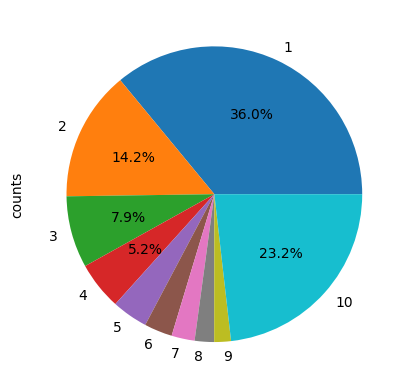

In [44]:
df_unoverlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


<Axes: ylabel='counts'>

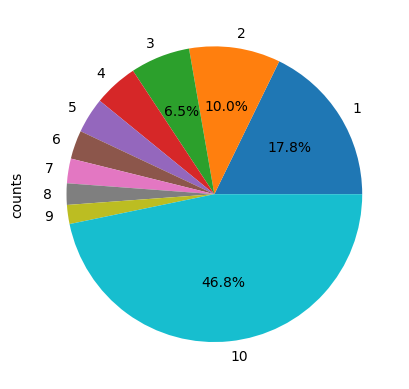

In [45]:
df_ovlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


In [46]:
df_deg = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mememto.csv")

In [47]:
df_wicox = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")

In [48]:
df_deg.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed",index=False,header=False, sep="\t")

In [49]:
# annotations = [
#     "/data2st1/junyi/generegion_vM23/intron_selected.bed",
#     "/data2st1/junyi/generegion_vM23/exon_selected.bed",
#     "/data2st1/junyi/generegion_vM23/promoter2k.bed",
#     #"/data2st1/junyi/generegion_vM23/repeat.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
#     "/data2st1/junyi/generegion_vM23/UTR.bed",
#     "/data2st1/junyi/generegion_vM23/CDS.bed",
#     "/data2st1/junyi/generegion_vM23/genebody.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
# ]

dict_annot_deg = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_deg[name] = df_annot
        print(f"Processed {file},{len(dict_annot_deg[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

# dict_annot_deg = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_deg[["names","ctname","condition"]],region_col='names', bedfile=file)
#         dict_annot_deg[name] = df_annot[df_annot.distance==0]
#         dict_annot_deg['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot_deg[name])}")
#     except Exception as e:
#         print(f"Error processing {file}, {e}")
        
#         continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,203276
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,162702
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,82062
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,5463
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,14913
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,6451
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,35159
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,33288


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,92889


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,52053


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,85759
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,59409


In [50]:
# df_wilcoxon = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")
# dict_annot_wil = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_wilcoxon[["names","ctname","condition"]],region_col='names', bedfile=file)
#         dict_annot_wil[name] = df_annot[df_annot.distance==0]
#         dict_annot_wil['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot_wil[name])}")
#     except Exception as e:
#         print(f"Error processing {file}, {e}")
        
#         continue

In [51]:
dict_annot_wil = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_wil[name] = df_annot
        print(f"Processed {file},{len(dict_annot_wil[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,172723
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,100534
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,48476
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,7629
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,15928
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,8691
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,20446
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,26395


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,55191


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,33160


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,66769
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,51557


In [52]:
inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", "/data2st1/junyi/generegion_vM23/UTR.bed")

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



In [53]:
inte_df = inte_dar_intron.to_dataframe()

In [54]:
inte_dar_me,non_overlapping_dar_mem = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", bed_rdhs)

In [55]:
n_ovlp_me = len(inte_dar_me.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar = len(df_deg)
non_ovlp_me = len(non_overlapping_dar_mem)

In [56]:
venn2(subsets=( n_dar-n_ovlp_me, n_rDHS-n_ovlp_me, n_ovlp_me), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of DAR and rDHS")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_rDHS.svg", dpi=300, bbox_inches='tight')
plt.close()

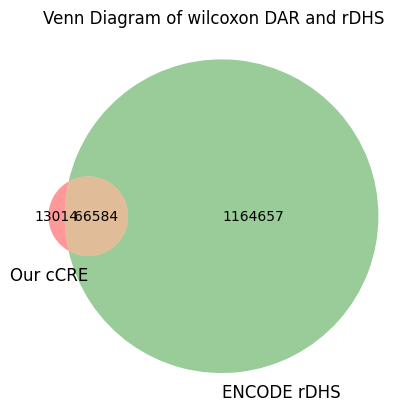

In [57]:
df_wil =pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", sep="\t", header=None)
inter_dar_wil ,non_overlapping_dar_wil = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", bed_rdhs)
n_ovlp_wil = len(inter_dar_wil.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar_wil = len(df_wil)
non_ovlp_wil = len(non_overlapping_dar_wil)
venn2(subsets=( n_dar_wil-n_ovlp_wil, n_rDHS-n_ovlp_wil, n_ovlp_wil), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of wilcoxon DAR and rDHS")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_wilcoxon_rDHS.svg", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

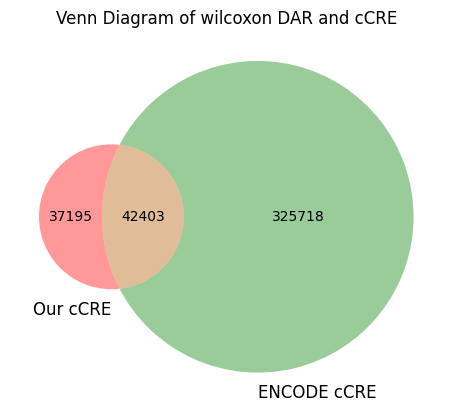

In [58]:
inter_dar_wil ,non_overlapping_dar_wil = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", bed_encode)
n_ovlp_wil = len(inter_dar_wil.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar_wil = len(df_wil)
non_ovlp_wil = len(non_overlapping_dar_wil)
venn2(subsets=( n_dar_wil-n_ovlp_wil, n_encodeCCRE-n_ovlp_wil, n_ovlp_wil), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of wilcoxon DAR and cCRE")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_wilcoxon_cCRE.svg", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [59]:
bed_encode

'/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed'

In [60]:
inte_dar_me.to_dataframe()

,chrom,start,end,name,score,strand,thickStart
0,chr12,120028551,120029052,chr12,120028506,120028717,EM10D2424368
1,chrX,143482812,143483313,chrX,143482912,143483195,EM10D2991266
2,chr1,183299141,183299642,chr1,183299148,183299498,EM10D2306186
3,chr2,181917507,181918008,chr2,181917990,181918164,EM10D1756799
4,chr13,3372900,3373401,chr13,3372809,3372960,EM10D1332641
...,...,...,...,...,...,...,...
132632,chr16,94919198,94919699,chr16,94919260,94919602,EM10D1538495
132633,chr8,105304519,105305020,chr8,105304605,105304949,EM10D2924863
132634,chr8,105304519,105305020,chr8,105304973,105305174,EM10D2924864
132635,chr17,66123319,66123820,chr17,66123180,66123342,EM10D1573524


In [61]:
inte_dar_me,non_overlapping_dar_mem = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", bed_encode)
n_ovlp_me = len(inte_dar_me.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar = len(df_deg)
non_ovlp_me = len(non_overlapping_dar_mem)

In [62]:
venn2(subsets=( n_dar-n_ovlp_me, n_encodeCCRE-n_ovlp_me, n_ovlp_me), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of DAR and cCRE")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_cCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

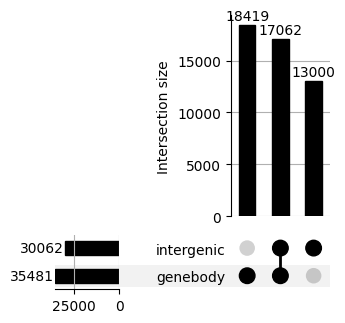

In [63]:
gene_regions = {
    'genebody': set(dict_annot_deg['genebody'].names),
    'intergenic': set(dict_annot_deg['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

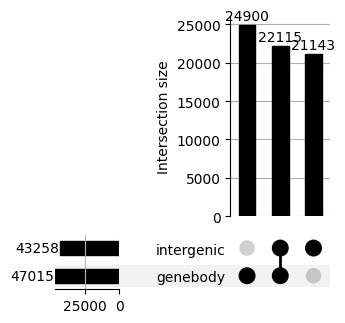

In [64]:
gene_regions = {
    'genebody': set(dict_annot_wil['genebody'].names),
    'intergenic': set(dict_annot_wil['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

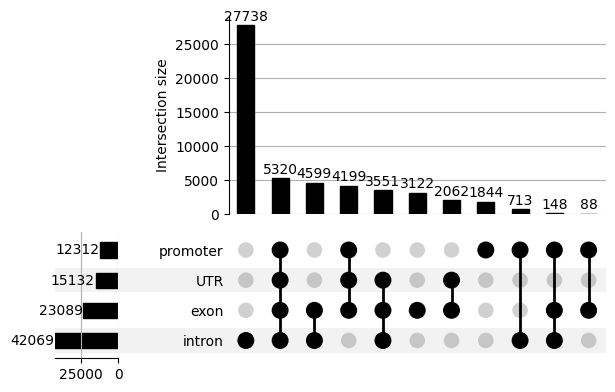

In [65]:
gene_regions = {
    'intron': set(dict_annot_wil['intron_selected'].names+"_"+dict_annot_wil['intron_selected'].gene_name),
    'exon': set(dict_annot_wil['exon_selected'].names+"_"+dict_annot_wil['exon_selected'].gene_name),
    'promoter': set(dict_annot_wil['promoter2k'].names+"_"+dict_annot_wil['promoter2k'].gene_name),
    'UTR': set(dict_annot_wil['UTR'].names+"_"+dict_annot_wil['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

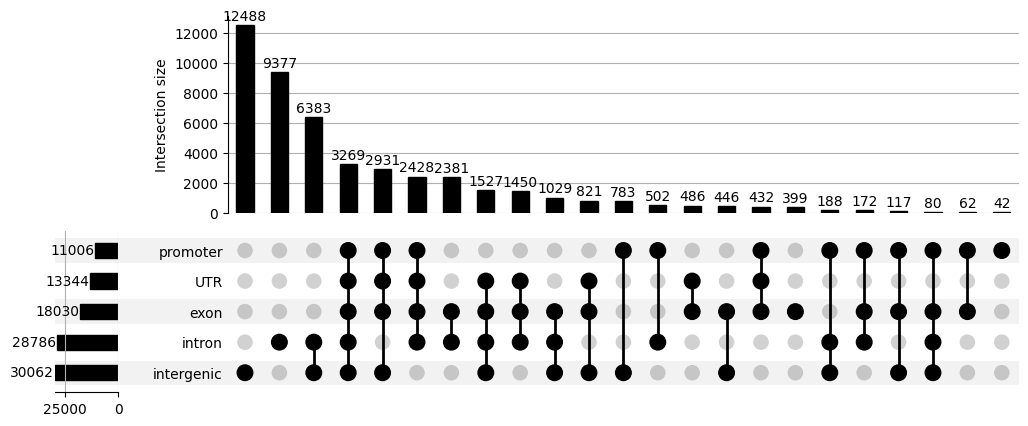

In [93]:
gene_regions = {
    'intron': set(dict_annot_deg['intron_selected'].names),
    'exon': set(dict_annot_deg['exon_selected'].names),
    'promoter': set(dict_annot_deg['promoter2k'].names),
    'UTR': set(dict_annot_deg['UTR'].names),
    'intergenic': set(dict_annot_deg['intergenic'].names),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

In [94]:
df_puei=gene_regions.reset_index()

In [95]:
df_puei = get_proity_region(df_puei)

/tmp/ipykernel_1954143/2052237438.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'intergenic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_in.loc[df_in[column]==True,"annotation"] = column


In [ ]:
#df_puei.rename(columns={"id":"names"},inplace=True)

In [96]:
df_puei

,promoter,UTR,exon,intron,intergenic,id,annotation
0,True,True,True,True,False,chr14:52279217-52279718,promoter
1,False,False,True,True,False,chr7:105810448-105810949,exon
2,False,False,False,True,False,chr7:111531251-111531752,intron
3,False,False,True,True,False,chr8:71535508-71536009,exon
4,False,False,False,True,True,chr16:67310960-67311461,intron
...,...,...,...,...,...,...,...
47788,False,False,False,False,True,chr16:29198455-29198956,intergenic
47789,False,False,False,False,True,chr13:70217346-70217847,intergenic
47790,False,False,False,False,True,chr9:25075928-25076429,intergenic
47791,False,False,False,False,True,chr9:98158351-98158852,intergenic


<Axes: ylabel='counts'>

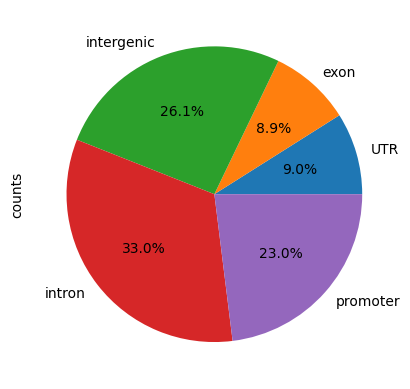

In [97]:
df_puei_c= df_puei.groupby("annotation").size().reset_index(name='counts')
df_puei_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [87]:
np.percentile(df_deg["distance"].values, 95)

11660.5

In [89]:
np.percentile(df_deg["distance"].values, 5)

-10518.0

array([[<Axes: title={'center': 'distance'}>]], dtype=object)

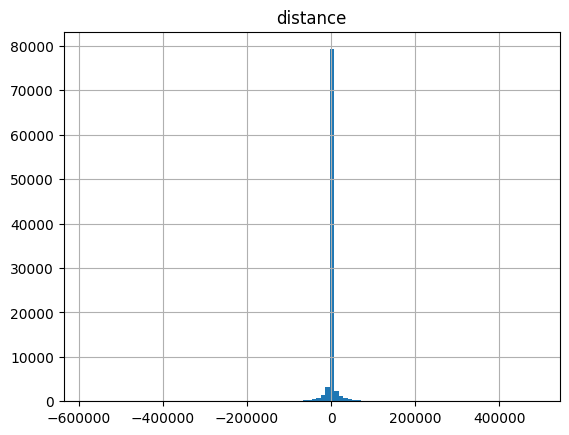

In [95]:
df_deg.hist(column="distance", bins=100)


(0.0, 1000.0)

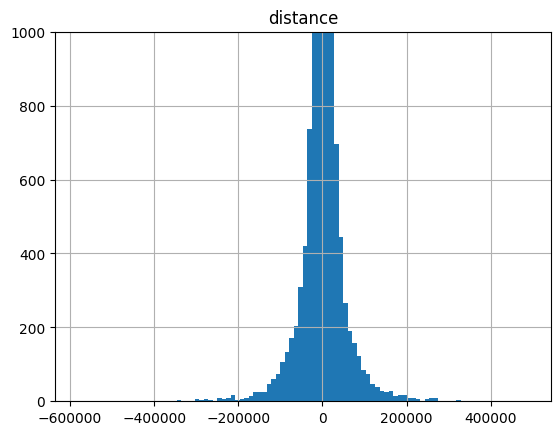

In [190]:
df_deg.hist(column="distance", bins=100)
plt.ylim(0, 1000)

In [78]:
df_deg_sc = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_degdar.csv")

In [79]:
df_deg_sc

,names,tx_atac,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,ctname,region_atac,...,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj,gender,region_sc,coefsq
0,chr1:83277007-83277508,stim,0.064208,0.026943,1.795282e-02,-0.083507,0.089878,0.392945,HIP_Glut,HIP,...,0.012693,0.006586,2.701066e-02,0.024031,0.020235,1.385319e-01,4.621218e-02,M,HIP,0.000815
1,chr11:106036520-106037021,stim,0.037918,0.017178,2.777225e-02,-0.031701,0.074309,0.651702,HIP_Glut,HIP,...,0.026356,0.015091,4.040336e-02,-0.023197,0.051847,9.529257e-01,6.662823e-02,M,HIP,0.000999
2,chr17:10840047-10840548,stim,0.047129,0.020066,1.932432e-02,-0.062015,0.075327,0.328981,HIP_Glut,HIP,...,0.022640,0.006539,2.680272e-04,-0.033708,0.021733,9.190023e-01,6.312235e-04,M,HIP,0.001067
3,chr18:42511126-42511627,stim,0.038978,0.017931,3.277798e-02,-0.038046,0.083258,0.642106,AMY_Glut,AMY,...,0.028715,0.013500,4.058440e-02,-0.063733,0.057795,1.894664e-01,5.161603e-02,M,AMY,0.001119
4,chr13:45571634-45572135,stim,0.089018,0.036493,1.223988e-02,0.195376,0.172441,0.225864,HIP_Glut,HIP,...,0.012813,0.005592,1.099404e-02,-0.044280,0.022664,1.354242e-01,2.014129e-02,M,HIP,0.001141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595,chr4:130273608-130274109,stim,-0.385962,0.025369,2.804666e-52,-0.106136,0.076006,0.163422,PFC_Glut,PFC,...,-0.477123,0.038815,5.193567e-35,0.068346,0.091080,5.554822e-01,1.040120e-33,M,PFC,0.184151
14596,chr8:94153479-94153980,stim,-0.245864,0.090137,7.051152e-03,0.409917,0.235845,0.076353,PFC_GABA,PFC,...,-0.763961,0.059908,2.991821e-37,-0.201831,0.195720,3.113190e-01,1.282232e-34,M,PFC,0.187830
14597,chr4:130270057-130270558,stim,-0.396485,0.023176,9.553611e-66,0.017376,0.073406,0.759935,PFC_Glut,PFC,...,-0.477123,0.038815,5.193567e-35,0.068346,0.091080,5.554822e-01,1.040120e-33,M,PFC,0.189172
14598,chr16:38694918-38695419,stim,-0.589476,0.034100,1.244633e-66,-0.248587,0.080133,0.002682,PFC_Glut,PFC,...,-0.332983,0.039688,2.771829e-17,-0.174910,0.155097,2.725293e-01,2.054442e-16,M,PFC,0.196286


In [98]:
df_puei['names'] = df_puei['id'].str.split("_").str[0]

In [99]:
df_puei.set_index('names', inplace=True)


In [100]:
df_puei_sc = df_puei.loc[list(set(df_deg_sc.names.values).intersection(set(df_puei.index.values)))]

<Axes: ylabel='counts'>

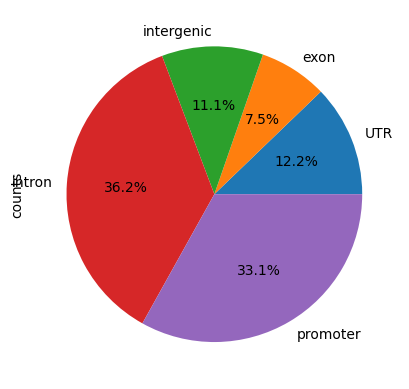

In [101]:
df_puei_sc_c=df_puei_sc.groupby("annotation").size().reset_index(name='counts')
df_puei_sc_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [102]:
df_puei

,promoter,UTR,exon,intron,intergenic,id,annotation
names,,,,,,,
chr14:52279217-52279718,True,True,True,True,False,chr14:52279217-52279718,promoter
chr7:105810448-105810949,False,False,True,True,False,chr7:105810448-105810949,exon
chr7:111531251-111531752,False,False,False,True,False,chr7:111531251-111531752,intron
chr8:71535508-71536009,False,False,True,True,False,chr8:71535508-71536009,exon
chr16:67310960-67311461,False,False,False,True,True,chr16:67310960-67311461,intron
...,...,...,...,...,...,...,...
chr16:29198455-29198956,False,False,False,False,True,chr16:29198455-29198956,intergenic
chr13:70217346-70217847,False,False,False,False,True,chr13:70217346-70217847,intergenic
chr9:25075928-25076429,False,False,False,False,True,chr9:25075928-25076429,intergenic


In [108]:
df_deg_merge = df_deg.merge(df_puei[['annotation']], on="names", how="left")
df_deg_merge["annotation_y"] = df_deg_merge["annotation_y"].fillna("intergenic")

In [113]:
df_deg_sc_merge = df_deg_sc.merge(df_puei[['annotation']], on="names", how="left")
df_deg_sc_merge["annotation"] = df_deg_sc_merge["annotation"].fillna("intergenic")

In [115]:
df_deg_merge.columns

Index(['names', 'tx', 'de_coef', 'de_se', 'de_pval', 'dv_coef', 'dv_se',
       'dv_pval', 'ctname', 'region', 'condition', 'gene_name', 'gene_id',
       'gstart', 'gend', 'strand', 'annotation_x', 'distance', 'de_pval_adj',
       'annotation_y'],
      dtype='object')

In [125]:
df_deg_merge

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation_x,distance,de_pval_adj,annotation_y
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,9.510063e-86,intergenic
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306,3.234648e-81,intergenic
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,4.431668e-61,intergenic
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,6.164123e-57,exon
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,7.114042e-43,exon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0,4.945411e-02,intron
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0,4.947963e-02,intron
92128,chr16:94919198-94919699,stim,-0.121242,0.062304,4.937179e-02,0.194725,0.213193,3.660465e-01,AMY_GABA,AMY,MW,Kcnj6,ENSMUSG00000043301.16,94748635,94997701,-,genebody,0,4.948458e-02,intron
92129,chr8:105304519-105305020,stim,-0.134731,0.067952,4.939417e-02,0.467569,0.196791,1.478859e-02,AMY_GABA,AMY,MW,E2f4,ENSMUSG00000014859.9,105297662,105305370,+,genebody,0,4.950109e-02,promoter


/tmp/ipykernel_1954143/2674298623.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

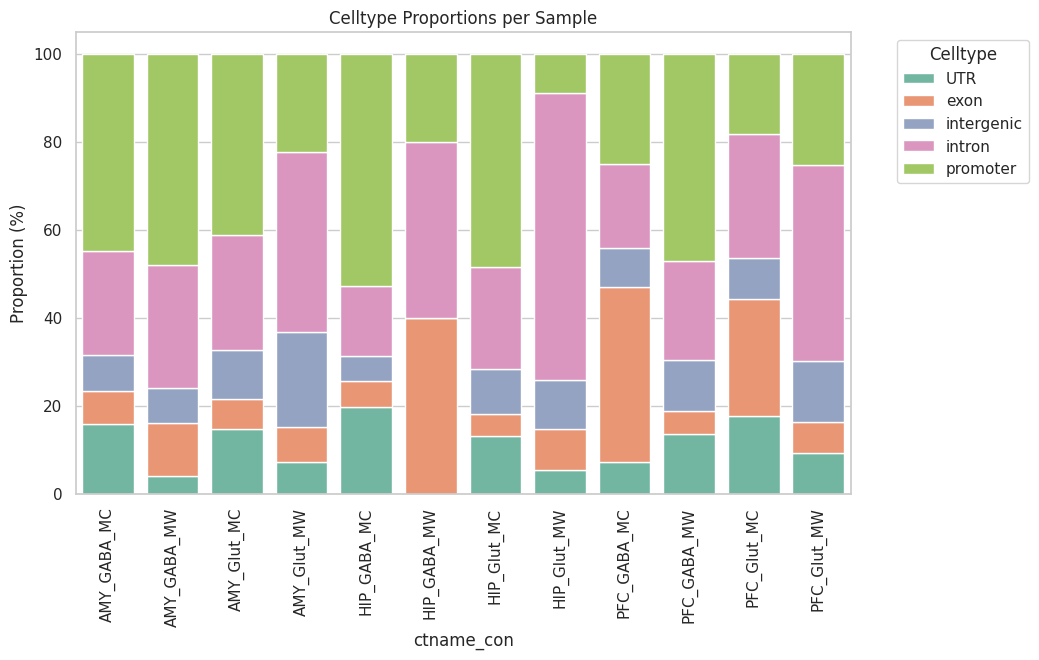

In [ ]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i]
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

#order = meta_atac.sort_values('Region')['sample'].unique()
df_deg_sc_merge['ctname_con'] = df_deg_sc_merge['ctname'].astype(str) + "_" + df_deg_sc_merge['condition'].astype(str)
plot_stack_prop(df_deg_sc_merge,x='ctname_con', y='proportion',pro_col="annotation",x_order=None, figsize=(10, 6))

/tmp/ipykernel_1954143/2674298623.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname', ylabel='Proportion (%)'>)

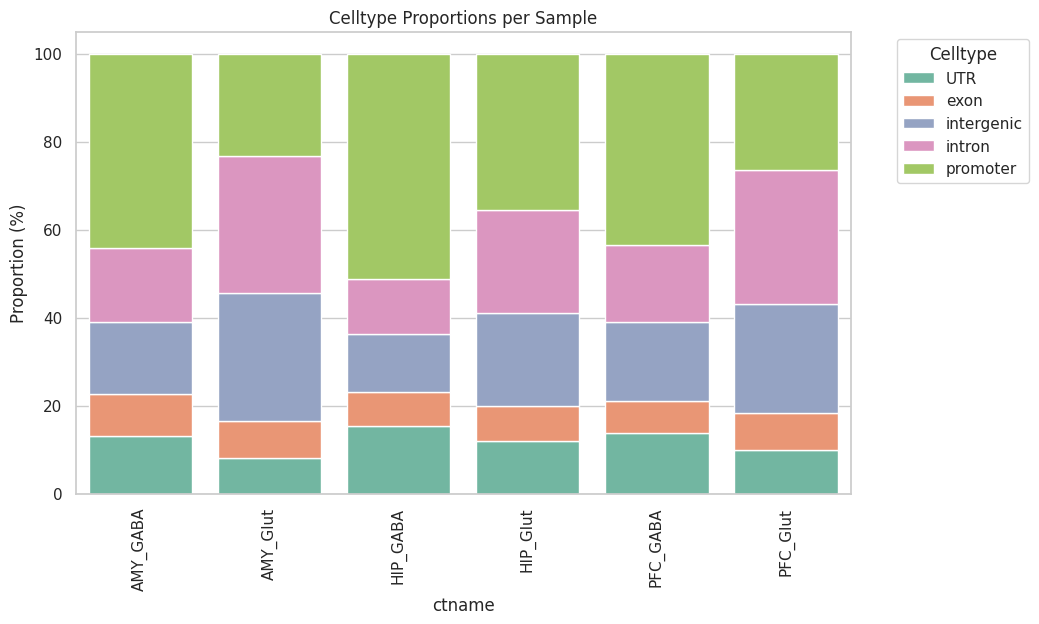

In [134]:
df_deg_merge['ctname_con'] = df_deg_merge['ctname'].astype(str) + "_" + df_deg_merge['condition'].astype(str)
plot_stack_prop(df_deg_merge,x='ctname', y='proportion',pro_col="annotation_y",x_order=None, figsize=(10, 6))

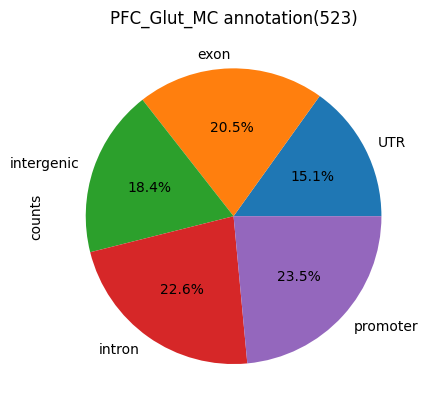

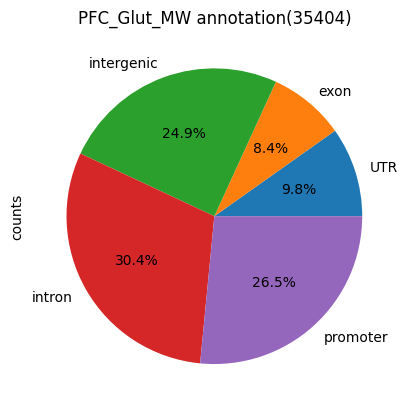

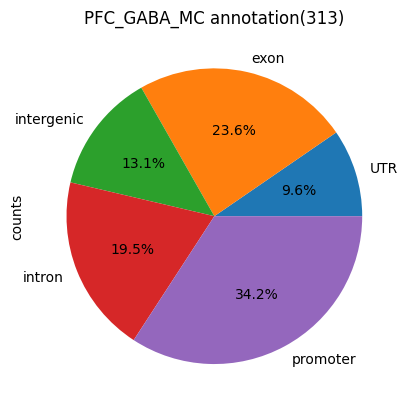

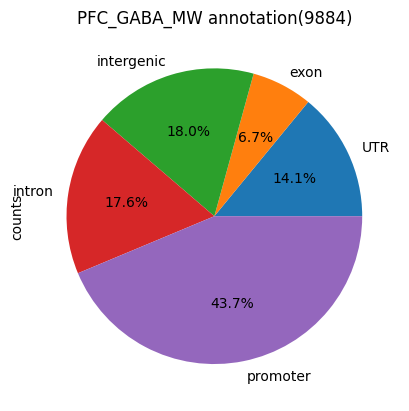

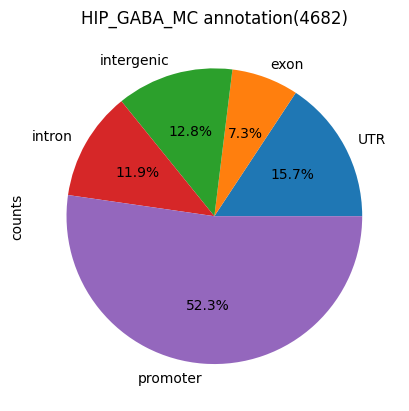

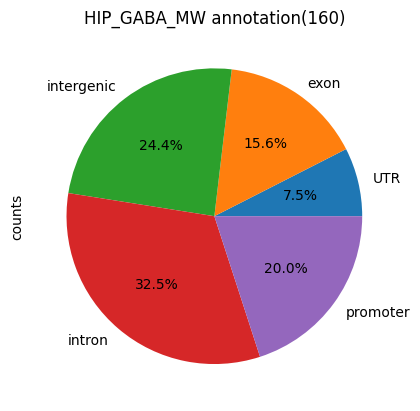

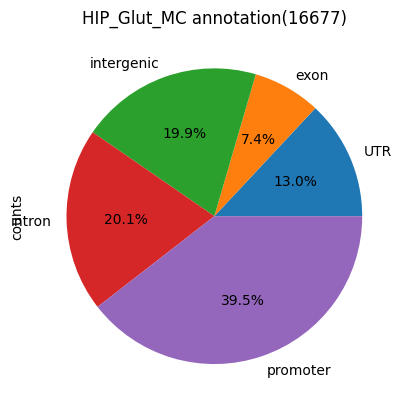

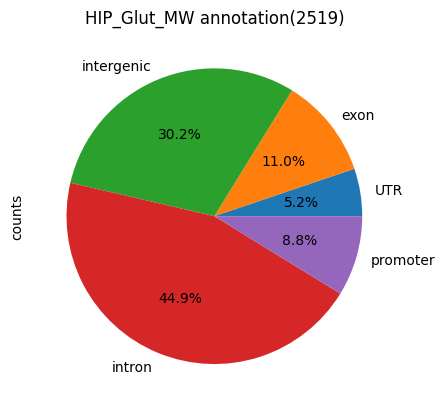

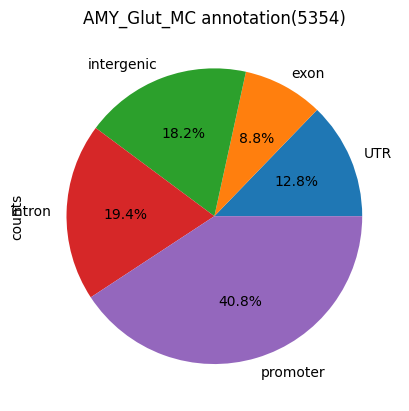

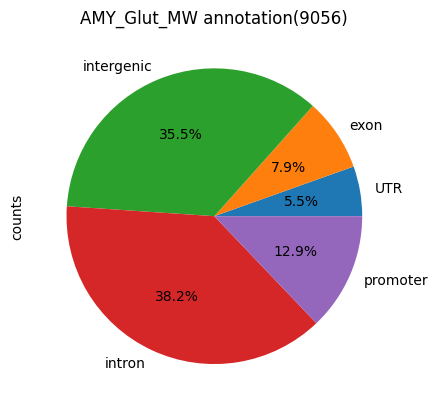

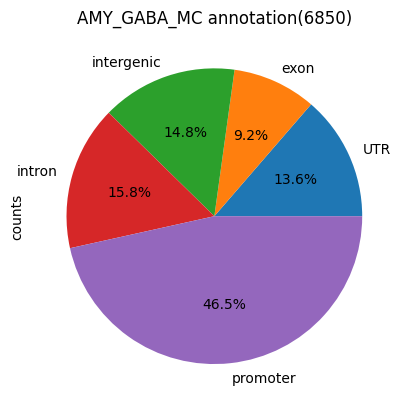

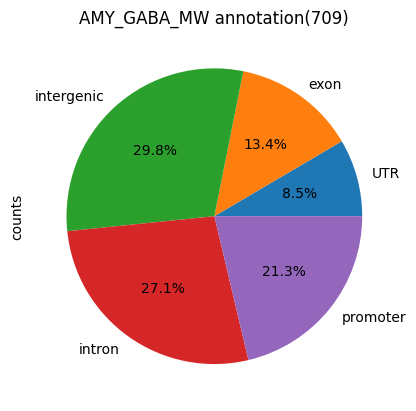

In [122]:
for ct in df_deg_merge.ctname.unique():
    for con in df_deg_merge.condition.unique():
        df_temp = df_deg_merge[(df_deg_merge.ctname==ct) & (df_deg_merge.condition==con)]
        df_tem_group = df_temp.groupby("annotation_y").size().reset_index(name='counts')
        
        df_tem_group.set_index('annotation_y').plot.pie(
            y='counts',
            autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
            legend=False,
            title=f"{ct}_{con} annotation" + f"({df_tem_group['counts'].sum()})",
        )
        

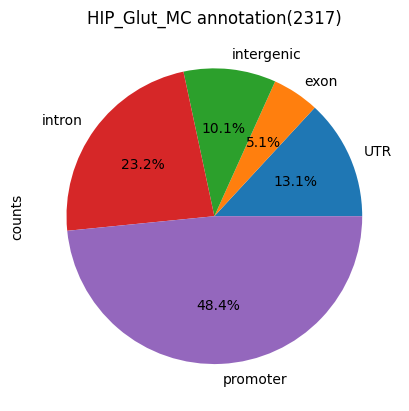

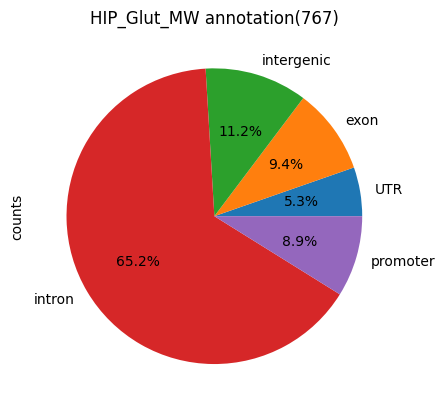

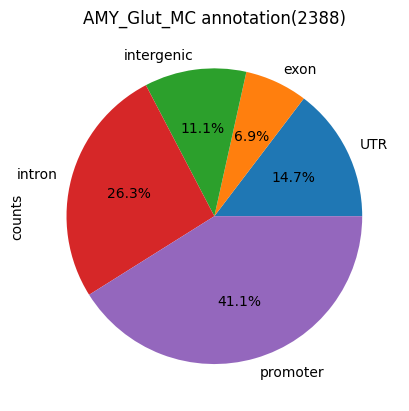

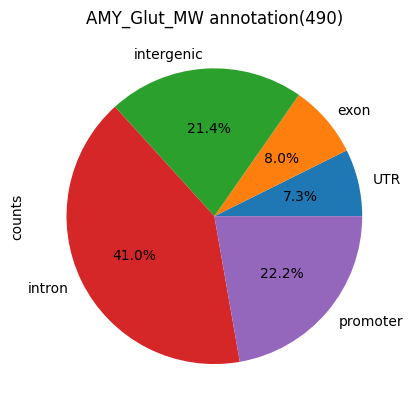

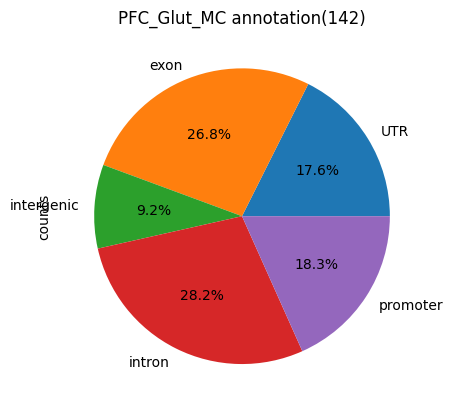

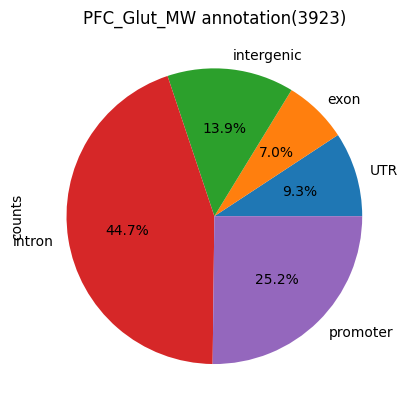

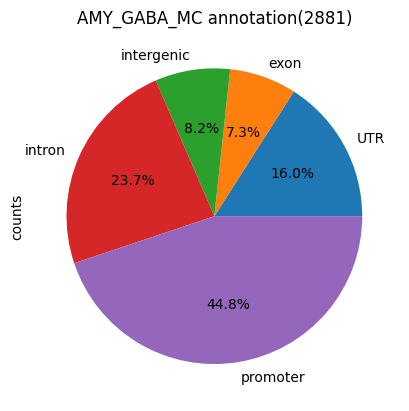

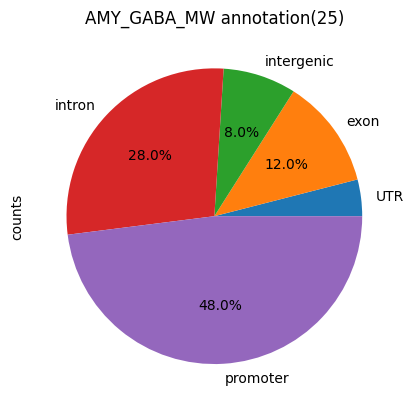

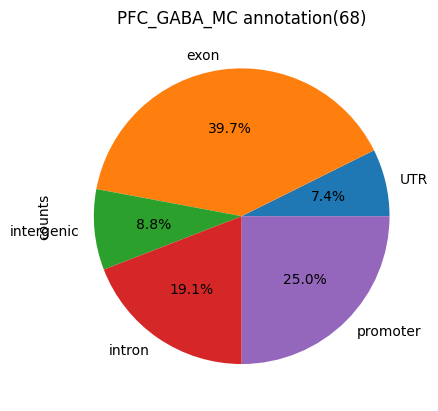

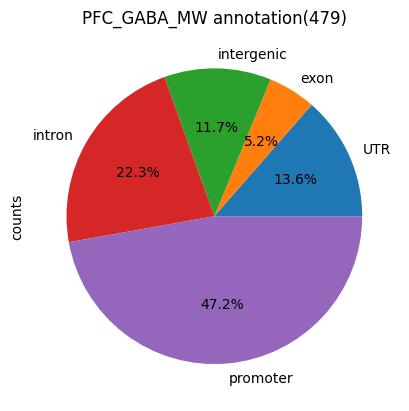

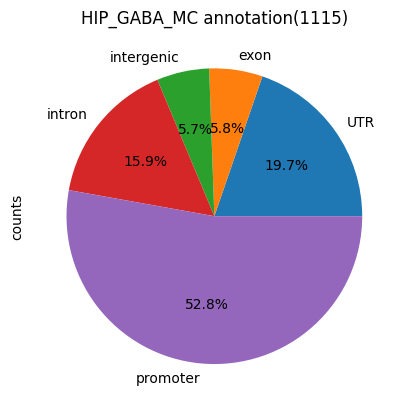

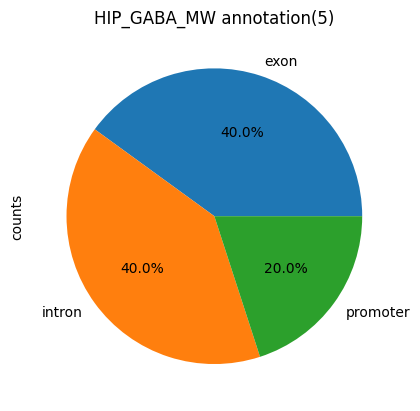

In [123]:
for ct in df_deg_sc_merge.ctname.unique():
    for con in df_deg_sc_merge.condition.unique():
        df_temp = df_deg_sc_merge[(df_deg_sc_merge.ctname==ct) & (df_deg_sc_merge.condition==con)]
        df_tem_group = df_temp.groupby("annotation").size().reset_index(name='counts')
        
        df_tem_group.set_index('annotation').plot.pie(
            y='counts',
            autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
            legend=False,
            title=f"{ct}_{con} annotation" + f"({df_tem_group['counts'].sum()})",
        )

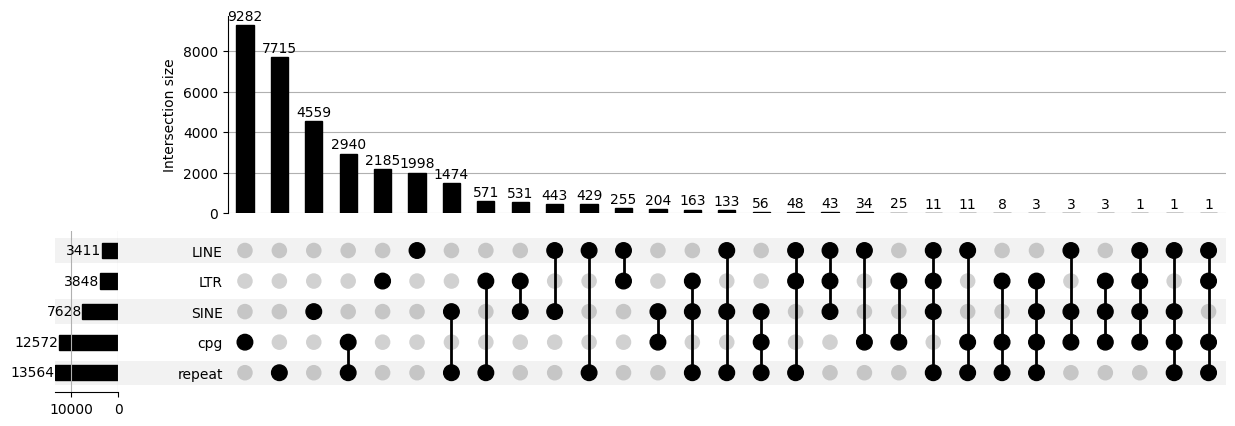

In [62]:
gene_regions = {
    'LINE': set(dict_annot_deg['LINE'].names+"_"+dict_annot_deg['LINE'].gene_name),
    'SINE': set(dict_annot_deg['SINE'].names+"_"+dict_annot_deg['SINE'].gene_name),
    'LTR': set(dict_annot_deg['LTR'].names+"_"+dict_annot_deg['LTR'].gene_name),
    'repeat': set(dict_annot_deg['Other_repeats'].names+"_"+dict_annot_deg['Other_repeats'].gene_name),
    'cpg': set(dict_annot_deg['cpg'].names+"_"+dict_annot_deg['cpg'].gene_name)
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()
    

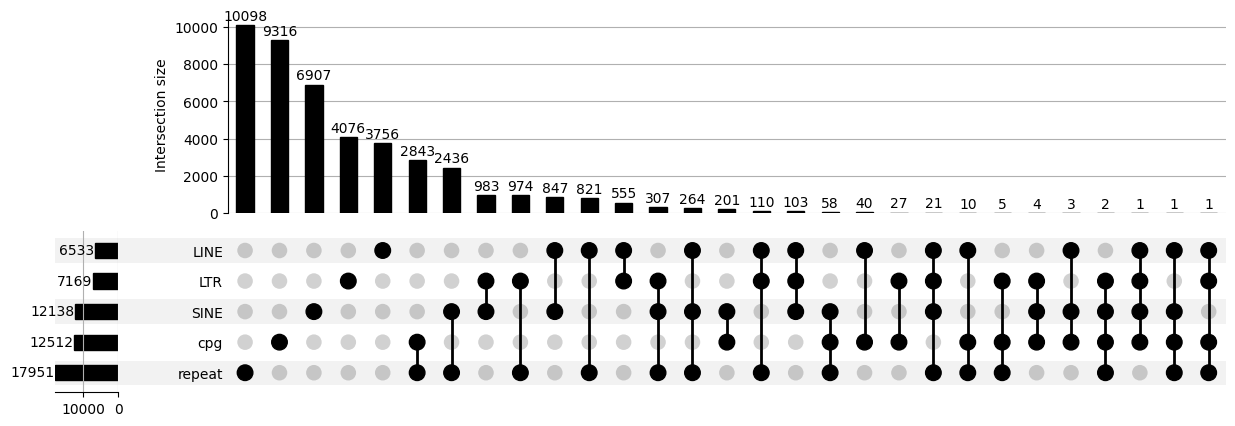

In [63]:
gene_regions = {
    'LINE': set(dict_annot_wil['LINE'].names+"_"+dict_annot_wil['LINE'].gene_name),
    'SINE': set(dict_annot_wil['SINE'].names+"_"+dict_annot_wil['SINE'].gene_name),
    'LTR': set(dict_annot_wil['LTR'].names+"_"+dict_annot_wil['LTR'].gene_name),
    'repeat': set(dict_annot_wil['Other_repeats'].names+"_"+dict_annot_wil['Other_repeats'].gene_name),
    'cpg': set(dict_annot_wil['cpg'].names+"_"+dict_annot_wil['cpg'].gene_name)
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()
    

In [64]:
df_dar_region_count = gene_regions.reset_index()
df_dar_region_count['count'] = df_dar_region_count.iloc[:,:-1].sum(axis=1)

In [65]:
df_dar_region_count.sort_values(by='count', ascending=False, inplace=True)

In [66]:
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
def geom_dar(T,n,dict_annot,dict_annot_deg):
    # T = len(df_allpeaks)
    # n = len(df_)
    # n = len(df_)
    list_name = []
    list_p = []
    list_odd = []
    list_fold = []
    list_pctb = []
    list_pctdar = []
    for key in dict_annot.keys():
        M = len(dict_annot[key].drop_duplicates(subset=["chrom","start","end"]))
        m = len(dict_annot_deg[key].drop_duplicates(subset=["chrom","start","end"]))
        p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验
        Oddr = (m / (n - m)) / ((M - m) / (T - M - n + m))
        fold_enrichment = (m / n) / (M / T)
        pct_background = M / T
        pct_dar = m / n

        # print(T, M,n, m)

        # contingency_table = [[m, M - m], [n - m, T - M - n + m]]
        # Oddr, p_value_fisher = fisher_exact(contingency_table, alternative='greater')


        list_name.append(key)
        list_p.append(p_value)
        list_odd.append(Oddr)
        list_fold.append(fold_enrichment)
        list_pctb.append(pct_background)
        list_pctdar.append(pct_dar)

    df_geom = pd.DataFrame({
        'name': list_name,
        'p_value': list_p,
        'Oddr': list_odd,
        'fold_enrichment': list_fold,
        'pct_background': list_pctb,
        'pct_dar': list_pctdar
    })
    df_geom['significant'] = df_geom['p_value'].apply(lambda x: 'yes' if x < 0.05 else 'no')
    
    return df_geom
# T = len(df_allpeaks)
# n = len(df_deg)
# # n = len(df_)
# list_name = []
# list_p = []
# list_odd = []
# list_fold = []
# list_pctb = []
# list_pctdar = []
# for key in dict_annot.keys():
#     M = len(dict_annot[key].drop_duplicates(subset=["chrom","start","end"]))
#     m = len(dict_annot_deg[key].drop_duplicates(subset=["chrom","start","end"]))
#     p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验
#     Oddr = (m / (n - m)) / ((M - m) / (T - M - n + m))
#     fold_enrichment = (m / n) / (M / T)
#     pct_background = M / T
#     pct_dar = m / n

#     # print(T, M,n, m)

#     # contingency_table = [[m, M - m], [n - m, T - M - n + m]]
#     # Oddr, p_value_fisher = fisher_exact(contingency_table, alternative='greater')


#     print(f"{key}: {p_value}, {Oddr}, {fold_enrichment}")
#     list_name.append(key)
#     list_p.append(p_value)
#     list_odd.append(Oddr)
#     list_fold.append(fold_enrichment)
#     list_pctb.append(pct_background)
#     list_pctdar.append(pct_dar)


In [67]:
df_deg[["names","ctname","condition","region"]]

,names,ctname,condition,region
0,chr15:75086569-75087070,PFC_Glut,MC,PFC
1,chr12:120028551-120029052,PFC_Glut,MC,PFC
2,chrX:143482812-143483313,PFC_Glut,MC,PFC
3,chr2:98662045-98662546,PFC_Glut,MC,PFC
4,chr2:98662628-98663129,PFC_Glut,MC,PFC
...,...,...,...,...
92126,chr8:110465569-110466070,AMY_GABA,MW,AMY
92127,chr2:29669624-29670125,AMY_GABA,MW,AMY
92128,chr16:94919198-94919699,AMY_GABA,MW,AMY
92129,chr8:105304519-105305020,AMY_GABA,MW,AMY


In [68]:
def gen_dict_with_query(dict_annot, qstring,df_deg):
    dict_merge = {}
    #subset_col = 'region'
    #qstring = 'condition.str.contains("MC")'
    for key in dict_annot.keys():
        df_merge = dict_annot_deg[key].merge(df_deg[["names","ctname","condition","region"]], on="names", how="left")
        result = df_merge.query(qstring)
        dict_merge[key] = result
    return dict_merge

In [69]:
df_deg.drop_duplicates(subset=["names"])

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance,de_pval_adj
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,9.510063e-86
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306,3.234648e-81
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,4.431668e-61
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,6.164123e-57
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,7.114042e-43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92123,chr11:60176417-60176918,stim,-0.088886,0.045841,4.912257e-02,-0.419944,0.150944,5.957374e-03,AMY_GABA,AMY,MW,Rai1,ENSMUSG00000062115.15,60105012,60199197,+,genebody,0,4.928932e-02
92124,chr2:158743696-158744197,stim,-0.142601,0.073285,4.912315e-02,0.005755,0.198035,9.877142e-01,AMY_GABA,AMY,MW,Ppp1r16b,ENSMUSG00000037754.13,158665397,158766334,+,genebody,0,4.928932e-02
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0,4.945411e-02
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0,4.947963e-02


In [70]:
df_wil

,0,1,2
0,chr2,98666917,98667418
1,chr2,98662045,98662546
2,chr2,98666414,98666915
3,chr9,35305176,35305677
4,chr2,98662628,98663129
...,...,...,...
79593,chr2,149768495,149768996
79594,chr12,41674762,41675263
79595,chr2,28068461,28068962
79596,chr5,71011211,71011712


In [71]:
T = len(df_allpeaks)
n = len(df_deg.drop_duplicates(subset=["names"]))
df_geom_mem = geom_dar(T,n,dict_annot,dict_annot_deg)
n2 = len(df_wil.drop_duplicates())
df_geom_wil = geom_dar(T,n2,dict_annot,dict_annot_wil)

<Axes: xlabel='fold_enrichment', ylabel='name'>

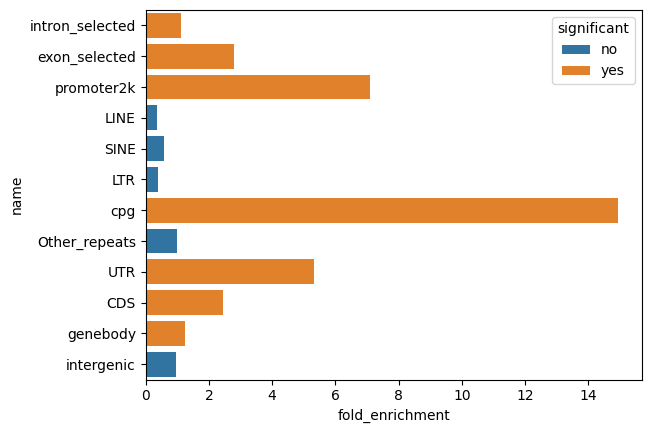

In [72]:
sns.barplot(data=df_geom_mem, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

<Axes: xlabel='fold_enrichment', ylabel='name'>

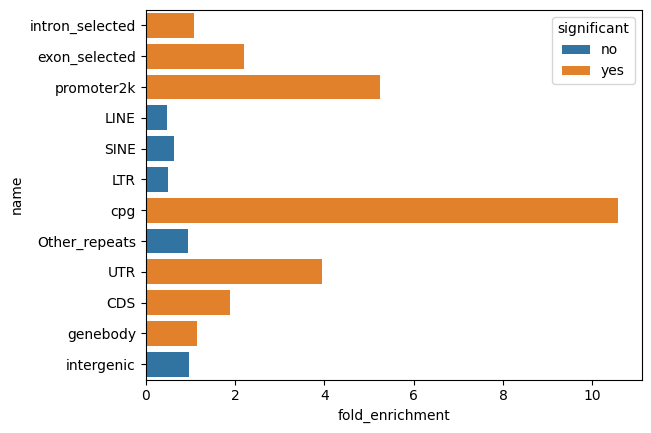

In [73]:
sns.barplot(data=df_geom_wil, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

In [74]:
qstring = 'condition.str.contains("MC") and ctname.str.contains("PFC_GABA")'
dic_merge_mem = gen_dict_with_query(dict_annot, qstring,df_deg)
len_mc = len(df_deg.query(qstring).names.unique())
df_geom_memMC = geom_dar(T,len_mc,dict_annot,dic_merge_mem)
df_geom_memMC
#sns.barplot(data=df_geom_memMC, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

,name,p_value,Oddr,fold_enrichment,pct_background,pct_dar,significant
0,intron_selected,4.462339e-11,2.189199,1.338039,0.534853,0.715655,yes
1,exon_selected,1.945113e-88,10.549715,4.657340,0.132396,0.616613,yes
2,promoter2k,1.078064e-77,15.774783,10.700224,0.031948,0.341853,yes
3,LINE,1.000000e+00,0.172540,0.206945,0.200699,0.041534,no
4,SINE,1.000000e+00,0.320698,0.394543,0.275322,0.108626,no
5,LTR,1.000000e+00,0.248397,0.294069,0.206424,0.060703,no
6,cpg,2.155822e-163,48.640371,26.566743,0.017317,0.460064,yes
7,Other_repeats,1.172305e-06,1.762806,1.462891,0.268627,0.392971,yes
8,UTR,3.132647e-54,9.143287,6.429548,0.051678,0.332268,yes
9,CDS,3.682160e-58,8.383881,5.453086,0.072650,0.396166,yes


In [75]:
df_geom_memMC

,name,p_value,Oddr,fold_enrichment,pct_background,pct_dar,significant
0,intron_selected,4.462339e-11,2.189199,1.338039,0.534853,0.715655,yes
1,exon_selected,1.945113e-88,10.549715,4.657340,0.132396,0.616613,yes
2,promoter2k,1.078064e-77,15.774783,10.700224,0.031948,0.341853,yes
3,LINE,1.000000e+00,0.172540,0.206945,0.200699,0.041534,no
4,SINE,1.000000e+00,0.320698,0.394543,0.275322,0.108626,no
5,LTR,1.000000e+00,0.248397,0.294069,0.206424,0.060703,no
6,cpg,2.155822e-163,48.640371,26.566743,0.017317,0.460064,yes
7,Other_repeats,1.172305e-06,1.762806,1.462891,0.268627,0.392971,yes
8,UTR,3.132647e-54,9.143287,6.429548,0.051678,0.332268,yes
9,CDS,3.682160e-58,8.383881,5.453086,0.072650,0.396166,yes


In [ ]:
bed_intron = "/data2st1/junyi/generegion_vM33/intron.bed"

intron, non_intron = intersect_bed_files(bed_allpeaks, bed_intron)

df_intron = intron.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])

num_intron = len(df_intron)

In [ ]:
df_intron.to_csv("/data2st1/junyi/output/cCRE/ALL_sampled_peaks_intron.bed", sep="\t", index=False)

In [ ]:
bed_intron = "/data2st1/junyi/generegion_vM33/exon.bed"
exon = BedTool(bed_intron)
exon, non_ie = intersect_bed_objects(non_intron, exon)


In [ ]:
df_exon = exon.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_exon = len(df_exon)

In [ ]:
promoter = BedTool("/data2st1/junyi/generegion_vM33/promoter.bed")
promoter, non_iep = intersect_bed_objects(non_ie, promoter)
df_promoter = promoter.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_promoter = len(df_promoter)

In [ ]:
SINES = BedTool("/data2st1/junyi/generegion_vM33/sines.bed")
SINES, non_sines = intersect_bed_files(non_iep, SINES)
df_sines = SINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_sines = len(df_sines)

In [ ]:
LTRS = BedTool("/data2st1/junyi/generegion_vM33/ltrs.bed")
LTRS, non_LTRS = intersect_bed_files(non_iep, LTRS)
df_ltrs = LTRS.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_ltrs = len(df_ltrs)

In [ ]:
LINES = BedTool("/data2st1/junyi/generegion_vM33/lines.bed")
LINES, non_LINES = intersect_bed_files(non_iep, LINES)
df_lines = LINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_lines = len(df_lines)


In [ ]:
intergenic = '/data2st1/junyi/generegion_vM33/intergenic.bed'
intergenic, non_intergenic = intersect_bed_files(bed_allpeaks, intergenic)
df_intergenic = intergenic.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_intergenic = len(df_intergenic)

In [ ]:
other_repeat = '/data2st1/junyi/generegion_vM33/other_repeats.bed'
other_repeat, non_other_repeat = intersect_bed_files(non_iep, other_repeat)
df_other_repeat = other_repeat.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_other_repeat = len(df_other_repeat)

In [ ]:
cpgi = '/data2st1/junyi/generegion_vM33/cpg.bed'
cpgi, non_cpgi = intersect_bed_files(bed_allpeaks, cpgi)
df_cpgi = cpgi.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_cpgi = len(df_cpgi)

In [ ]:
num_cpgi

In [ ]:
import seaborn as sns

data = {'Region': ['Intron', 'Exon', 'Promoter', 'SINES', 'LTRs', 'LINES', 'Intergenic', 'Other Repeats', 'CpG Islands'],
        'Number of Peaks': [num_intron, num_exon, num_promoter, num_sines, num_ltrs, num_lines, num_intergenic, num_other_repeat, num_cpgi]}
df = pd.DataFrame(data)


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df['Number of Peaks'], labels=df['Region'], autopct='%1.1f%%',pctdistance=1.15,labeldistance=1.28)
plt.show()


In [ ]:
# import subprocess
# filename= '/data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed'
# command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed"
# print(command_str)
# subprocess.run(command_str, shell=True)

In [ ]:
# bed_allpeaks = "/data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed"
# bed_encode = "/data2st1/junyi/output/convert_enhancer.bed"

# merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [ ]:
# merged.saveas("/data2st1/junyi/output/cCRE/merged_mm10.bed")
# non_overlapping.saveas("/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed")

In [192]:

# 打开 bigWig 文件
bw_pcon = "/data2st1/junyi/phascon/mm10.60way.phastCons.bw"

In [196]:
def cal_pasconscore(input_bed, input_bw):

    bw = pyBigWig.open(input_bw)
    
    scores_list_non = []

    with open(input_bed, "r") as bed_file:
        for line in bed_file:
            line_s = line.strip().split('\t')
            chrom, start, end= line_s[0], line_s[1], line_s[2]
            start = int(start)
            end = int(end)
            summit = (start +
                    end) // 2
            

            # 获取 PhastCons 分数
            try:
                scores = bw.values(chrom, summit -250, summit + 250)
                scores = [score for score in scores if score is not None]
            except:
                continue    
            # 计算平均分数
            # mean_score = np.mean(scores)
            # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
            scores_list_non.append(scores)

    scores_array_non = np.array(scores_list_non)
    scores_array_non = np.nan_to_num(scores_array_non)
    #mean_value_non = np.mean(scores_array_non, axis=0)

    return scores_array_non

In [207]:
df_dar_wil = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")

In [211]:
df_dar_wil.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed",index=False,header=False, sep="\t")

In [197]:
ovlp_rdhs = "/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed"
scores_array = cal_pasconscore(ovlp_rdhs, bw_pcon)
mean_value = np.mean(scores_array, axis=0)

In [198]:
# 
non_ovlp_rdhs = "/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed"
scores_array_non = cal_pasconscore(non_ovlp_rdhs, bw_pcon)
mean_value_non = np.mean(scores_array_non, axis=0)

In [199]:
dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
mean_value_dar = np.mean(scores_array_dar, axis=0)

In [ ]:
dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
mean_value_dar = np.mean(scores_array_dar, axis=0)

In [212]:
wil_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed"
scores_array_wil = cal_pasconscore(wil_bed, bw_pcon)
mean_value_wil = np.mean(scores_array_wil, axis=0)

In [200]:
sns.set_style("whitegrid")


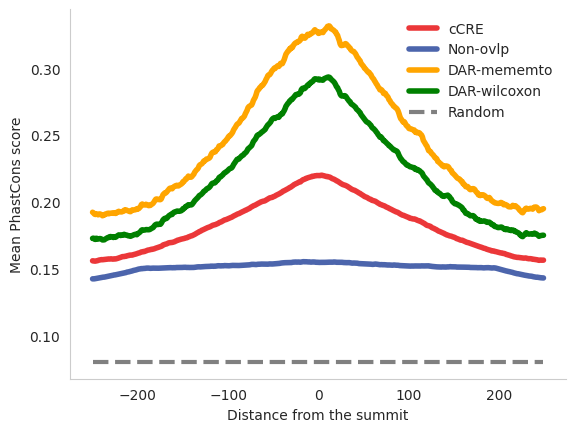

In [213]:
x = np.arange(-250, 250)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.plot(x, mean_value,color='#EB3739', label='cCRE',linewidth=4)
plt.plot(x, mean_value_non, color='#4C65AC', label='Non-ovlp',linewidth=4)
plt.plot(x, mean_value_dar, color='Orange', label='DAR-mememto',linewidth=4)
plt.plot(x, mean_value_wil, color='green', label='DAR-wilcoxon',linewidth=4)
plt.plot(x, np.zeros_like(x)+0.08, color='grey',label='Random', linestyle='--', linewidth=3)
plt.xlabel('Distance from the summit')
plt.ylabel('Mean PhastCons score')
plt.legend(loc='upper right',frameon=False)
plt.grid(visible=False)
plt.axis('tight')
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.show()

